In [1]:
# For training
from keras.applications import VGG16
from keras import models, optimizers, layers
from keras.preprocessing.image import ImageDataGenerator
# Testing plugin
from livelossplot import PlotLossesKeras

/home/sagacius/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
height = 256
width = 256
batch_size = 50
train_dir = 'CD/train/'
validation_dir = 'CD/validation/'
test_dir = 'CD/test/'

In [3]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, 3))
vgg_conv.trainable = False
#print(len(vgg_conv.trainable_weights))
"""set_trainable = False
for layer in vgg_conv.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False"""
#print(len(vgg_conv.trainable_weights))
vgg_conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [4]:
model = models.Sequential()

model.add(vgg_conv)

#model.add(layers.Flatten())
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dense(163, activation='sigmoid'))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

#model.summary()

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

val_batchsize = int(batch_size / 10)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(height, width),
    batch_size=val_batchsize,
    class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.01),
              metrics=['acc'])

Found 12757 images belonging to 10 classes.
Found 3646 images belonging to 10 classes.


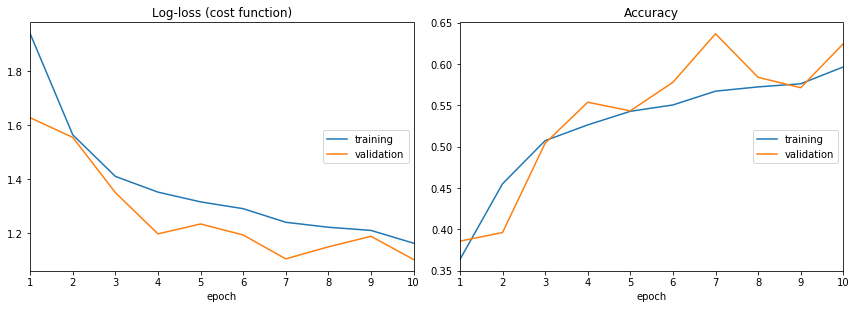

In [6]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    callbacks=[PlotLossesKeras()],
    verbose=1)

In [7]:
model.save('Models/CD_mark2.h5')

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [9]:
import numpy as np
nacc = np.asarray(acc)
nval_acc = np.asarray(val_acc)
nloss = np.asarray(loss)
nval_loss = np.asarray(val_loss)
logs_mark = np.row_stack((nacc, nval_acc, nloss, nval_loss))

In [10]:
np.save("Logs/CD_mark1.npy", logs_mark)

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

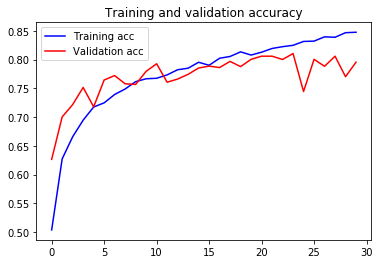

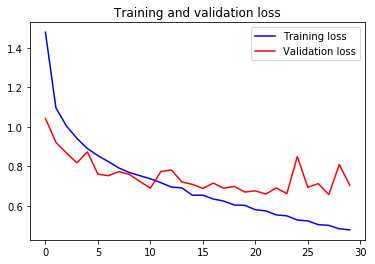

In [14]:
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [20]:
testing_generator = validation_datagen.flow_from_directory(
        test_dir,
        target_size=(height, width),
        batch_size=val_batchsize,
        class_mode='categorical',
        shuffle=False)
 
# Get the filenames from the generator
fnames = testing_generator.filenames
 
# Get the ground truth from generator
ground_truth = testing_generator.classes
 
# Get the label to class mapping from the generator
label2index = testing_generator.class_indices
 
# Getting the mapping from class index to class label
idx2label = dict((v,k) for k,v in label2index.items())
 
# Get the predictions from the model using the generator
predictions = model.predict_generator(testing_generator, 
                                      steps=testing_generator.samples/testing_generator.batch_size,
                                      verbose=1)
predicted_classes = np.argmax(predictions,axis=1)
 
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),testing_generator.samples))
print(str(len(errors)/testing_generator.samples) + "%")

Found 1823 images belonging to 10 classes.
365/364 [==============================] - 13s 36ms/step
No of errors = 374/1823
0.20515633571036754%
